<a href="https://colab.research.google.com/github/poojamahajan0712/medium_blog/blob/master/regularisation/MNIST_with_L1_%26_L2_Regularisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
#1. Import libraries 
#!pip install torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt

In [ ]:
# 2. Loading and transforming dataset 
#Transformations
#Transforms are common image transformations. They can be chained together using Compose
transforms = transforms.Compose([
                                 transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))  
                                      
                                       ])

train = datasets.MNIST('./data', train=True, download=True, transform=transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=transforms)

SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
# For reproducibility
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

#you have to use data loader in PyTorch that will actually read the data within batch size and put into memory
# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


CUDA Available? True


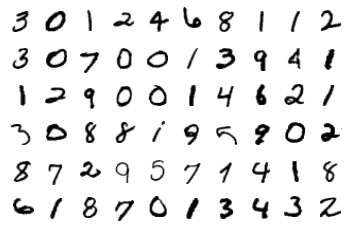

In [ ]:
#3 View few images from train data 
# loading one set of train data batch 

dataiter = iter(train_loader)
images, labels = dataiter.next()

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
#4 Building network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26  RF 3 Jout - 1

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24 RF 5 Jout -1

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 22 RF 7 Jout - 1

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11  RF 8 Jout - 2

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11  RF 8 Jout- 2

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 9  RF - 12 ,Jout - 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7 RF - 16  Jout - 2

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7  RF - 16  Jout - 2 
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1  RF -28  Jout - 2 
       
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
#5 Model Summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
print("Model Summary")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
Model Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             900
              ReLU-4           [-1, 10, 24, 24]               0
            Conv2d-5           [-1, 20, 22, 22]           1,800
              ReLU-6           [-1, 20, 22, 22]               0
         MaxPool2d-7           [-1, 20, 11, 11]               0
            Conv2d-8           [-1, 10, 11, 11]             200
              ReLU-9           [-1, 10, 11, 11]               0
           Conv2d-10             [-1, 10, 9, 9]             900
             ReLU-11             [-1, 10, 9, 9]               0
           Conv2d-12             [-1, 20, 7, 7]           1,800
             ReLU-13             [-1, 20, 7, 7]               0
           Conv2d-14

In [ ]:
#6 training the network 
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch,is_L1):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    ##Adding code for L1 Regularisation
    if(is_L1==True):
      
      l1_crit = nn.L1Loss(size_average=False)
      reg_loss = 0
      for param in model.parameters():
          reg_loss += l1_crit(param,target=torch.zeros_like(param))

      factor = 0.00005
      loss += factor * reg_loss
      train_losses.append(loss)

    else:
      train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))


In [ ]:

def train_model(is_L1,is_L2):
  model =  Net().to(device)
  
  if(is_L2==True):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.003)
  else:
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  EPOCHS = 20
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch,is_L1)
      test(model, device, test_loader)
  


a1=train_model(is_L1=True,is_L2=False)
a2=train_model(is_L1=False,is_L2=True)


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.5386833548545837 Batch_id=468 Accuracy=18.17: 100%|██████████| 469/469 [00:18<00:00, 25.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5806, Accuracy: 8431/10000 (84.31%)

EPOCH: 1


Loss=0.19637401401996613 Batch_id=468 Accuracy=93.42: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1309, Accuracy: 9604/10000 (96.04%)

EPOCH: 2


Loss=0.12098446488380432 Batch_id=468 Accuracy=96.75: 100%|██████████| 469/469 [00:17<00:00, 26.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0774, Accuracy: 9764/10000 (97.64%)

EPOCH: 3


Loss=0.1556466817855835 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:18<00:00, 26.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0552, Accuracy: 9811/10000 (98.11%)

EPOCH: 4


Loss=0.12711778283119202 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:17<00:00, 26.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9837/10000 (98.37%)

EPOCH: 5


Loss=0.11574988067150116 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:18<00:00, 26.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9836/10000 (98.36%)

EPOCH: 6


Loss=0.08930372446775436 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9844/10000 (98.44%)

EPOCH: 7


Loss=0.0976724624633789 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:18<00:00, 25.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9851/10000 (98.51%)

EPOCH: 8


Loss=0.0830644890666008 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:18<00:00, 25.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9861/10000 (98.61%)

EPOCH: 9


Loss=0.05373737961053848 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:17<00:00, 26.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9871/10000 (98.71%)

EPOCH: 10


Loss=0.03220042213797569 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:18<00:00, 25.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 9854/10000 (98.54%)

EPOCH: 11


Loss=0.04947695508599281 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:18<00:00, 26.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9872/10000 (98.72%)

EPOCH: 12


Loss=0.07426220178604126 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:18<00:00, 26.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9871/10000 (98.71%)

EPOCH: 13


Loss=0.13734856247901917 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:18<00:00, 25.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9875/10000 (98.75%)

EPOCH: 14


Loss=0.03895463049411774 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:18<00:00, 25.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9863/10000 (98.63%)

EPOCH: 15


Loss=0.04072784259915352 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:18<00:00, 25.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9863/10000 (98.63%)

EPOCH: 16


Loss=0.05274247005581856 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:18<00:00, 25.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0399, Accuracy: 9866/10000 (98.66%)

EPOCH: 17


Loss=0.03263307735323906 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 25.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9879/10000 (98.79%)

EPOCH: 18


Loss=0.03257207199931145 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:18<00:00, 25.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9877/10000 (98.77%)

EPOCH: 19


Loss=0.03047255426645279 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:18<00:00, 25.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9881/10000 (98.81%)

EPOCH: 0


Loss=2.300563097000122 Batch_id=468 Accuracy=19.04: 100%|██████████| 469/469 [00:16<00:00, 27.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3006, Accuracy: 3244/10000 (32.44%)

EPOCH: 1


Loss=0.21388286352157593 Batch_id=468 Accuracy=76.34: 100%|██████████| 469/469 [00:16<00:00, 28.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1704, Accuracy: 9432/10000 (94.32%)

EPOCH: 2


Loss=0.06555354595184326 Batch_id=468 Accuracy=95.79: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1039, Accuracy: 9653/10000 (96.53%)

EPOCH: 3


Loss=0.1382990926504135 Batch_id=468 Accuracy=97.03: 100%|██████████| 469/469 [00:16<00:00, 28.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0831, Accuracy: 9719/10000 (97.19%)

EPOCH: 4


Loss=0.06765540689229965 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:16<00:00, 27.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0601, Accuracy: 9799/10000 (97.99%)

EPOCH: 5


Loss=0.07235442847013474 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:16<00:00, 27.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0599, Accuracy: 9816/10000 (98.16%)

EPOCH: 6


Loss=0.02491951175034046 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:16<00:00, 27.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0565, Accuracy: 9816/10000 (98.16%)

EPOCH: 7


Loss=0.05864648520946503 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:16<00:00, 27.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9848/10000 (98.48%)

EPOCH: 8


Loss=0.04846085235476494 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0550, Accuracy: 9823/10000 (98.23%)

EPOCH: 9


Loss=0.025140101090073586 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:16<00:00, 27.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0675, Accuracy: 9790/10000 (97.90%)

EPOCH: 10


Loss=0.17043817043304443 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 9843/10000 (98.43%)

EPOCH: 11


Loss=0.017086083069443703 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:16<00:00, 27.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0667, Accuracy: 9801/10000 (98.01%)

EPOCH: 12


Loss=0.04297959432005882 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:16<00:00, 27.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0560, Accuracy: 9831/10000 (98.31%)

EPOCH: 13


Loss=0.022431299090385437 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:16<00:00, 27.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9849/10000 (98.49%)

EPOCH: 14


Loss=0.029050448909401894 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:17<00:00, 27.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9858/10000 (98.58%)

EPOCH: 15


Loss=0.0496344231069088 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:17<00:00, 27.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0516, Accuracy: 9829/10000 (98.29%)

EPOCH: 16


Loss=0.042201247066259384 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:16<00:00, 27.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0516, Accuracy: 9846/10000 (98.46%)

EPOCH: 17


Loss=0.09884349256753922 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:16<00:00, 27.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0597, Accuracy: 9804/10000 (98.04%)

EPOCH: 18


Loss=0.0460519902408123 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:16<00:00, 27.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9851/10000 (98.51%)

EPOCH: 19


Loss=0.016725823283195496 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:17<00:00, 27.43it/s]



Test set: Average loss: 0.0459, Accuracy: 9858/10000 (98.58%)



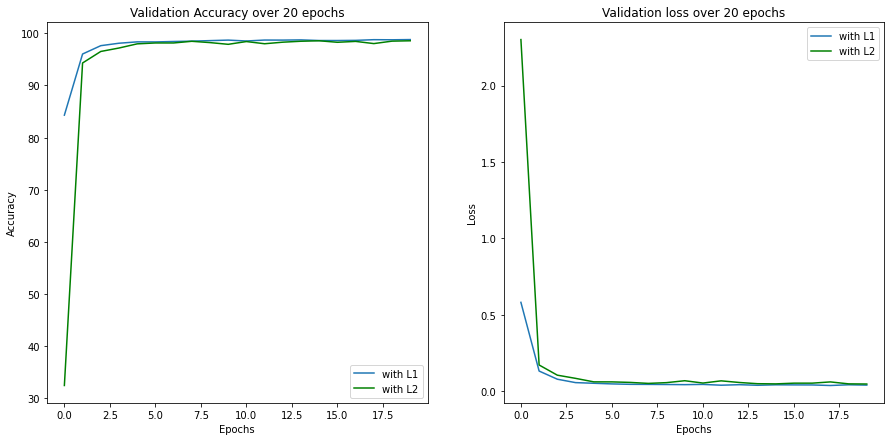

In [ ]:
from google.colab import files


fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.plot(test_acc[:20], label="with L1")
ax1.plot(test_acc[20:40], color="green", label="with L2")
ax1.set_title("Validation Accuracy over 20 epochs")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

#extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig('Accuracy_S6.png', bbox_inches=extent.expanded(1.1, 1.2))
#files.download("Accuracy_S6.png") 

ax2.plot(test_losses[:20],label="with L1")
ax2.plot(test_losses[20:40], color="green", label="with L2")
ax2.set_title("Validation loss over 20 epochs")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
#extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig('Loss_S6.png', bbox_inches=extent.expanded(1.1, 1.2))
#files.download("Loss_S6.png")